In [1]:
import os
from classification_models.tfkeras import Classifiers

# Import the ResNet34 model
ResNet34, preprocess_input = Classifiers.get('resnet34')

In [2]:
# Run only for training!
import glob
import math
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.preprocessing import normalize

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

# Change parameters here...
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)
data_dir = 'data/' 
sizex = 500
sizey = 500
sizez = 3
rand_seed = 123
num_datasets = -1
batch_size = 128
buf_size = 895
nb_epochs = 15
validation_ratio = 0.1

In [3]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'dataset*')

In [4]:
# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets[:num_datasets]:
    with np.load(dataset) as data:
        if 'x_dust' in data_dict.keys():
            data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
        else:
            data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']

In [5]:
# check the shape of the dictionary (100 images of 500x500x3 = 4 files of 25 images)
data_dict['x_dust'].shape

(895, 500, 500, 3)

In [6]:
# Compute the angles from the x,y,z labels
# theta = np.arctan(np.sqrt(x**2 + y**2)/z)
# phi = np.arctan(y/x)
def cart_to_esf(xyz):
    angles = np.empty( (len(xyz),2) )
    angles[:,0] = np.arctan2(np.sqrt(xyz[:,0]**2 + xyz[:,1]**2),xyz[:,2]) *180/np.pi #theta angle in degrees
    angles[:,1] = np.arctan2(xyz[:,1],xyz[:,0]) * 180/np.pi #phi angle in degrees
    return angles

# Define the function to go back to cartisian cordinates
def esf_to_cart(angles):
    xyz = np.empty( (len(angles),3) )
    ang_rad = angles*np.pi/180
    xyz[:,0] = np.sin(ang_rad[:,0])*np.cos(ang_rad[:,1])
    xyz[:,1] = np.sin(ang_rad[:,0])*np.sin(ang_rad[:,1])
    xyz[:,2] = np.cos(ang_rad[:,0])
    return xyz

#break the degeneracy of the solutions restricting the solution to 1 sector
def break_degeneracy(angles):
    ang_norm = angles
    for i in range(len(angles)):
        if ang_norm[:,1][i] < 0:
            ang_norm[:,1][i] = (ang_norm[:,1][i] + 180)
    return ang_norm

#map the solution to be between [0,1]
def map_to_1(angles, max = 180 ):
    ang_norm = angles/max
    return ang_norm

#coming back the mapping from 1 to 180
def map_to_180(ang_norm):
  angle = ang_norm*180
  return angle

# computing the normaliced vectors in 3D
data_dict['y_norm'] = normalize(data_dict['y'], axis=1)

In [7]:
# check the shape of our dictionary in te labels entry
print(data_dict['y_norm'].shape)

(895, 3)


In [8]:
# separate in batches and shuffle the data with a fixed seed
#dataset = dataset.batch(batch_size)
#dataset = dataset.shuffle(10, seed=123)
AUTO = tf.data.experimental.AUTOTUNE

In [9]:
# functions to visualice the data 
def viz(img, label, pred=np.array([0,0,0]), id=None):
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
    ax.arrow(250,250,100*label[0],100*label[1], head_width=7, head_length=10, fc='g', ec='g')
    if np.sum(np.abs(pred)) > 0: ax.arrow(250,250,100*pred[0],100*pred[1], head_width=7, head_length=10, fc='r', ec='r')
        
    display(Markdown("#### **cartesian label:** {}".format(label)))
    if np.sum(np.abs(pred)) > 0: display(Markdown("#### **cartesian prediction (x_y):** {}".format(pred)))
    if id: display(Markdown("#### **ID:** {}".format(id)))
    plt.show()

# create the dataset from the dictionary and see the size and type
dataset = tf.data.Dataset.from_tensor_slices(data_dict)
print(dataset)

<TensorSliceDataset shapes: {x_dust: (500, 500, 3), x_nodust: (500, 500, 3), y: (3,), ids: (), y_norm: (3,)}, types: {x_dust: tf.float64, x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_norm: tf.float64}>


#### **cartesian label:** [0.91321264 0.07612517 0.40030942]

#### **ID:** b'g3.54e09_x174_y289_z10'

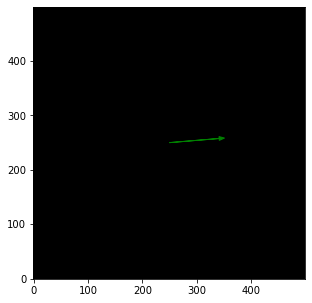

#### **cartesian label:** [-0.86259336  0.32798186  0.38517605]

#### **ID:** b'g3.59e11_x327_y67_z51'

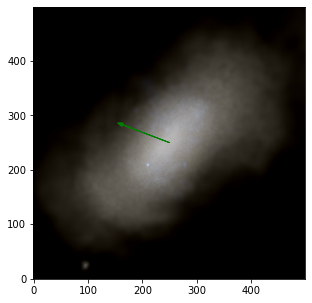

#### **cartesian label:** [ 0.86984429 -0.45869166  0.18158434]

#### **ID:** b'g1.23e10_x250_y166_z131'

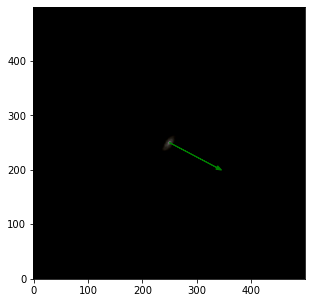

#### **cartesian label:** [-0.49327222  0.23212117 -0.83833303]

#### **ID:** b'g5.38e11_x207_y331_z254'

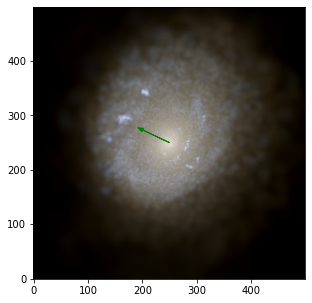

#### **cartesian label:** [-0.61369093  0.6727376  -0.41328872]

#### **ID:** b'g3.55e11_x221_y111_z121'

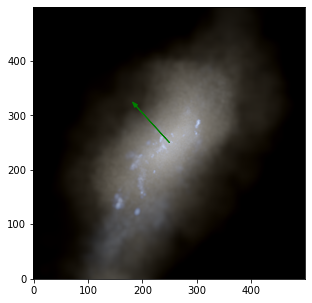

#### **cartesian label:** [-0.19316571  0.37082021  0.90839385]

#### **ID:** b'g5.36e11_x334_y80_z22'

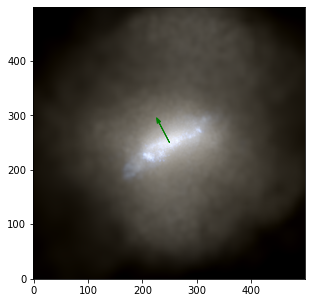

#### **cartesian label:** [-0.32922093  0.7162336   0.6153235 ]

#### **ID:** b'g1.23e10_x43_y149_z285'

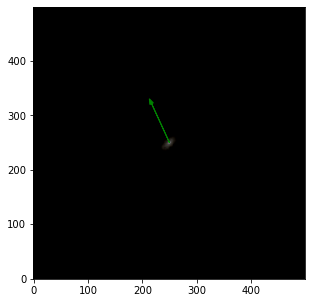

#### **cartesian label:** [-0.34257352 -0.90712284  0.2444822 ]

#### **ID:** b'g5.36e11_x322_y6_z166'

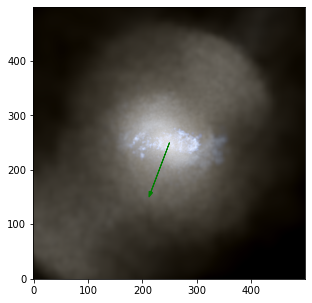

#### **cartesian label:** [-0.72355164  0.60583655 -0.33080975]

#### **ID:** b'g4.94e10_x123_y288_z247'

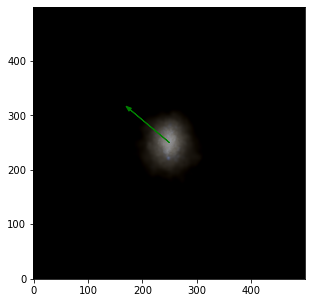

#### **cartesian label:** [0.66018449 0.69187025 0.29235593]

#### **ID:** b'g1.95e10_x123_y47_z338'

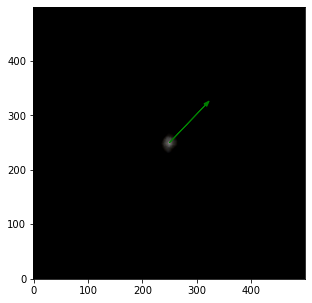

In [10]:
# visualice the data
real_dataset = dataset.batch(batch_size).shuffle(10, seed=rand_seed)
for idx in range(1,5):
    elements = real_dataset.take(idx)
    for elem in elements:
        viz(elem['x_nodust'][idx], elem['y_norm'][idx], id=elem['ids'][idx])

In [11]:
# defining the train and validation dataset from the existing dictionary, shufling and batching
ds_size = len(data_dict['y_norm'])

input_ds = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'].astype(np.float32), data_dict['y_norm'][:,:2].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False)
)

val_size = math.floor(ds_size * validation_ratio)
validation_ds = ( input_ds.take(val_size).batch(batch_size) )
train_ds = ( input_ds.skip(val_size).shuffle(buffer_size=buf_size, reshuffle_each_iteration=True).batch(batch_size) )

print(train_ds)
print(validation_ds)

<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [12]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --reload_multifile True --host 0.0.0.0 --port 6006

In [13]:
# Build model
base_model = ResNet34(input_shape=(sizey,sizex,3), weights='imagenet', include_top=False)

# redefine the output to be 2 parameters from the last dense layer
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(2, activation=None)(x)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

# Use existing best weights if available...
snapshot_weights = 'best_weights_cartesian_xy_dense.hdf5'
last_snapshot_weights = 'last_weights_angles_xy_dense.hdf5'
if os.path.isfile(last_snapshot_weights):
    print('loaded weights')
    model.load_weights(last_snapshot_weights)
    
model.compile(optimizer='SGD', loss='MeanSquaredError', metrics=['accuracy'])

In [14]:
# model.summary()

# For tensorboard
log_dir_s = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

# Checkpointing
checkpointer_1 = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True)
checkpointer_2 = tf.keras.callbacks.ModelCheckpoint(filepath=last_snapshot_weights,
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=False)

callbacks = [
    tensorboard_callback,
    checkpointer_1,
    checkpointer_2
]


model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = nb_epochs,
    callbacks = callbacks,)
    # class_weight=class_weight)

model.save('models/trained.h5') # Not really needed as we have the weights already

Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 16.0363 - accuracy: 0.4926 
Epoch 00001: val_accuracy improved from -inf to 0.53933, saving model to best_weights_cartesian_xy_dense.hdf5

Epoch 00001: saving model to last_weights_angles_xy_dense.hdf5
7/7 [==============================] - 188s 27s/step - loss: 16.0363 - accuracy: 0.4926 - val_loss: 1.5429 - val_accuracy: 0.5393
Epoch 2/15
7/7 [==============================] - ETA: 0s - loss: 0.8519 - accuracy: 0.5161 
Epoch 00002: val_accuracy did not improve from 0.53933

Epoch 00002: saving model to last_weights_angles_xy_dense.hdf5
7/7 [==============================] - 185s 26s/step - loss: 0.8519 - accuracy: 0.5161 - val_loss: 1.1797 - val_accuracy: 0.5393
Epoch 3/15
7/7 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.5372 
Epoch 00003: val_accuracy did not improve from 0.53933

Epoch 00003: saving model to last_weights_angles_xy_dense.hdf5
7/7 [==============================] - 186s 27s/s

In [15]:
model.save('models/trained_xy_mse.h5')

In [20]:
# taking samples from the validation dataset and evaluating the model
val_ex, = train_ds.take(1)
images, labels = val_ex[0], val_ex[1]
outputs = model.predict(images)

In [21]:
print(labels)
print(outputs)

tf.Tensor(
[[ 0.15599535 -0.7226274 ]
 [-0.7207743   0.06061189]
 [-0.52889186 -0.84487957]
 [ 0.9012378  -0.33413103]
 [ 0.47604182  0.8635267 ]
 [-0.44861233 -0.52127486]
 [-0.4294595   0.8791846 ]
 [ 0.29494193 -0.43530923]
 [ 0.50448936  0.49755648]
 [ 0.7204113  -0.04076435]
 [ 0.29663664  0.90440744]
 [-0.662174   -0.05474118]
 [ 0.2152222   0.725437  ]
 [-0.49714044  0.86733425]
 [ 0.43888375  0.8473473 ]
 [ 0.6172725  -0.63130885]
 [ 0.3274226   0.93293786]
 [-0.508374   -0.38357595]
 [ 0.8891578  -0.45496517]
 [ 0.6571171   0.7158306 ]
 [-0.07852341  0.5763887 ]
 [ 0.7951662   0.45135376]
 [-0.314533   -0.61335254]
 [-0.1562322   0.3077371 ]
 [-0.511279    0.40772927]
 [-0.04091451  0.24890578]
 [ 0.36730492 -0.928298  ]
 [-0.35816363 -0.6451965 ]
 [-0.3174594   0.36468253]
 [ 0.6130155  -0.6018811 ]
 [ 0.8134941  -0.14679067]
 [ 0.4706139   0.3174854 ]
 [ 0.13172308  0.03787146]
 [-0.5015657  -0.49663258]
 [ 0.7885064   0.03759363]
 [ 0.4260015  -0.8465752 ]
 [ 0.18716548 -0.

#### **cartesian label:** [ 0.15599535 -0.7226274 ]

#### **cartesian prediction (x_y):** [0.32365978 0.5342845 ]

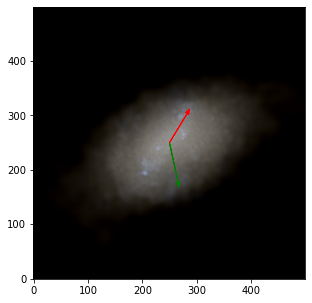

#### **cartesian label:** [-0.7207743   0.06061189]

#### **cartesian prediction (x_y):** [0.32952002 0.53165835]

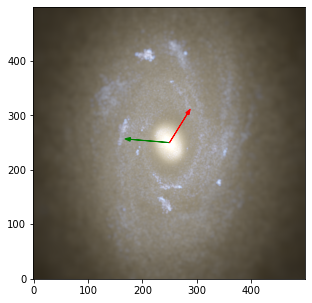

#### **cartesian label:** [-0.52889186 -0.84487957]

#### **cartesian prediction (x_y):** [0.32371518 0.53433555]

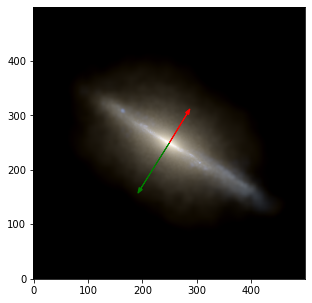

#### **cartesian label:** [ 0.9012378  -0.33413103]

#### **cartesian prediction (x_y):** [0.321242  0.5352934]

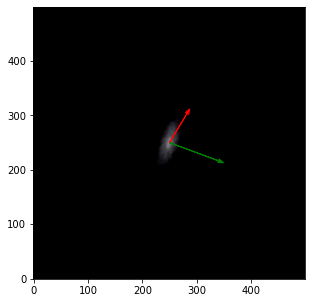

#### **cartesian label:** [0.47604182 0.8635267 ]

#### **cartesian prediction (x_y):** [0.32600918 0.5347343 ]

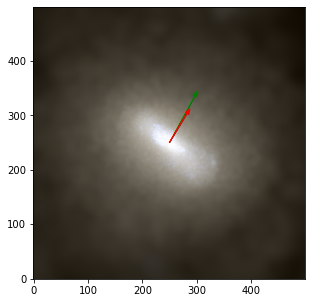

#### **cartesian label:** [-0.44861233 -0.52127486]

#### **cartesian prediction (x_y):** [0.32123244 0.5353424 ]

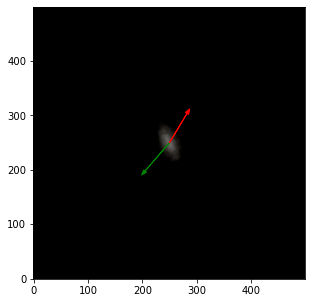

#### **cartesian label:** [-0.4294595  0.8791846]

#### **cartesian prediction (x_y):** [0.3218519  0.53516835]

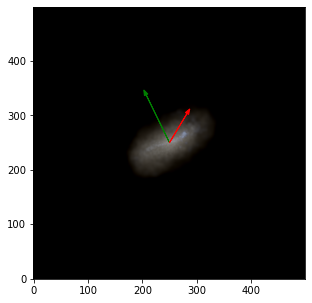

#### **cartesian label:** [ 0.29494193 -0.43530923]

#### **cartesian prediction (x_y):** [0.32686806 0.5319572 ]

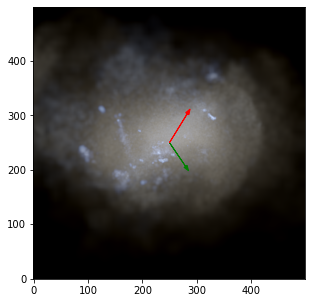

#### **cartesian label:** [0.50448936 0.49755648]

#### **cartesian prediction (x_y):** [0.32401803 0.5341051 ]

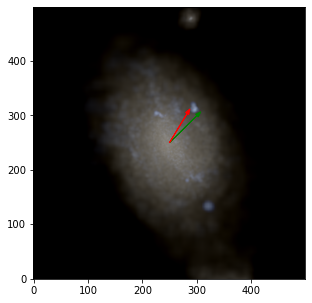

#### **cartesian label:** [ 0.7204113  -0.04076435]

#### **cartesian prediction (x_y):** [0.32654548 0.53402513]

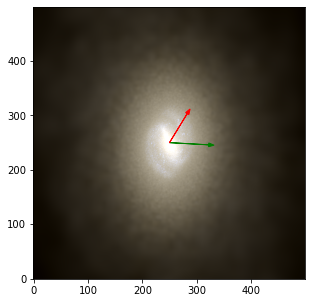

#### **cartesian label:** [0.29663664 0.90440744]

#### **cartesian prediction (x_y):** [0.324856   0.53413075]

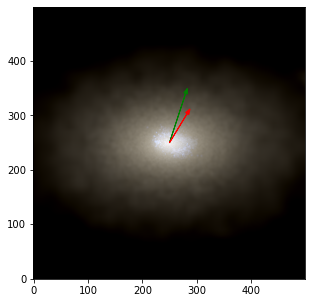

#### **cartesian label:** [-0.662174   -0.05474118]

#### **cartesian prediction (x_y):** [0.3301054 0.531073 ]

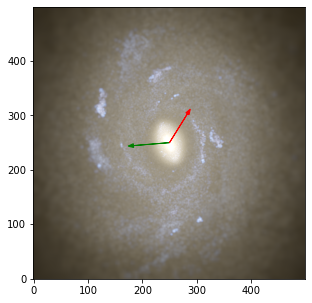

#### **cartesian label:** [0.2152222 0.725437 ]

#### **cartesian prediction (x_y):** [0.32135883 0.5353628 ]

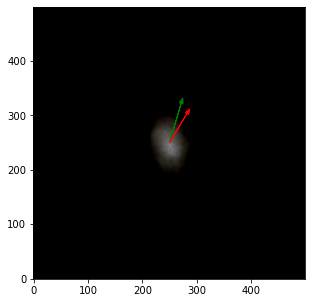

#### **cartesian label:** [-0.49714044  0.86733425]

#### **cartesian prediction (x_y):** [0.32288912 0.5349055 ]

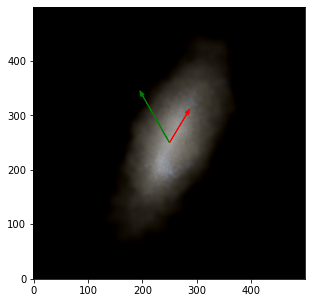

#### **cartesian label:** [0.43888375 0.8473473 ]

#### **cartesian prediction (x_y):** [0.32503676 0.5338833 ]

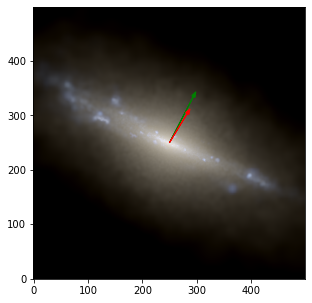

#### **cartesian label:** [ 0.6172725  -0.63130885]

#### **cartesian prediction (x_y):** [0.32127848 0.53535014]

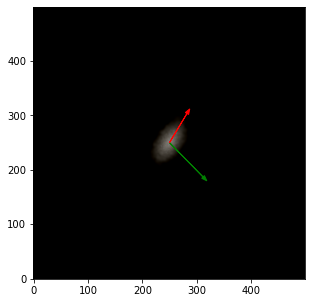

#### **cartesian label:** [0.3274226  0.93293786]

#### **cartesian prediction (x_y):** [0.3219166  0.53500986]

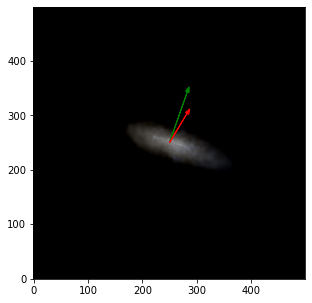

#### **cartesian label:** [-0.508374   -0.38357595]

#### **cartesian prediction (x_y):** [0.32125717 0.53531384]

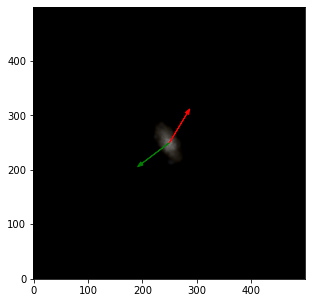

#### **cartesian label:** [ 0.8891578  -0.45496517]

#### **cartesian prediction (x_y):** [0.3246874  0.53470343]

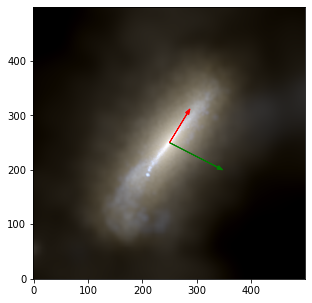

#### **cartesian label:** [0.6571171 0.7158306]

#### **cartesian prediction (x_y):** [0.32465062 0.5342537 ]

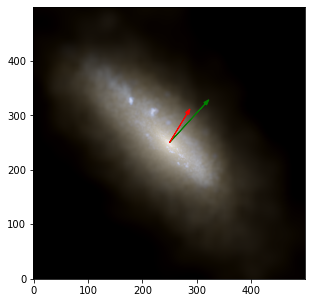

#### **cartesian label:** [-0.07852341  0.5763887 ]

#### **cartesian prediction (x_y):** [0.32161275 0.5350769 ]

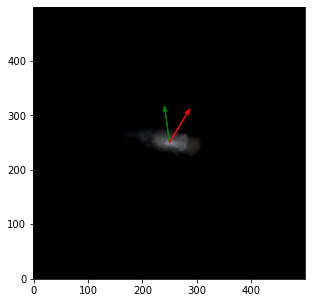

#### **cartesian label:** [0.7951662  0.45135376]

#### **cartesian prediction (x_y):** [0.32162312 0.53527486]

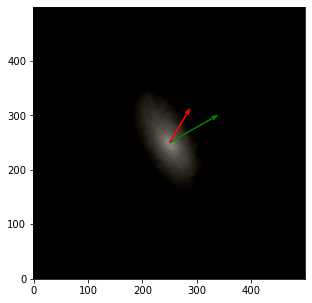

#### **cartesian label:** [-0.314533   -0.61335254]

#### **cartesian prediction (x_y):** [0.32107756 0.53537446]

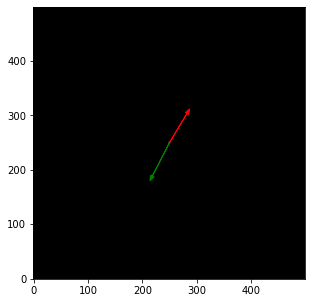

#### **cartesian label:** [-0.1562322  0.3077371]

#### **cartesian prediction (x_y):** [0.32709226 0.53135115]

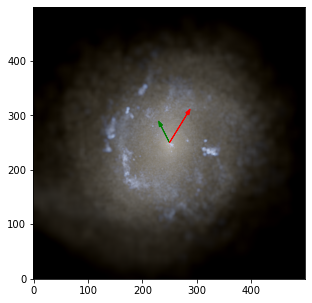

#### **cartesian label:** [-0.511279    0.40772927]

#### **cartesian prediction (x_y):** [0.32346776 0.5348483 ]

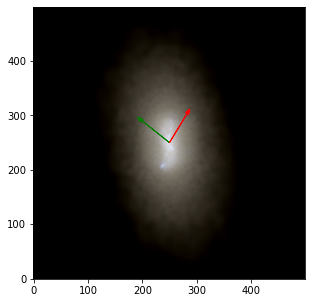

#### **cartesian label:** [-0.04091451  0.24890578]

#### **cartesian prediction (x_y):** [0.32201496 0.5350238 ]

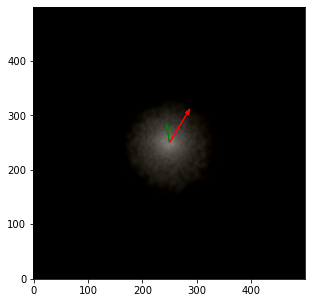

#### **cartesian label:** [ 0.36730492 -0.928298  ]

#### **cartesian prediction (x_y):** [0.3211617 0.5353609]

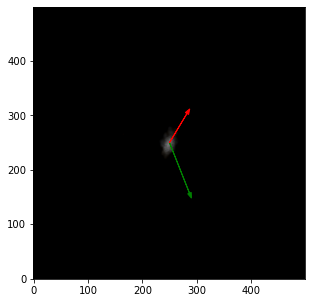

#### **cartesian label:** [-0.35816363 -0.6451965 ]

#### **cartesian prediction (x_y):** [0.32576975 0.53268564]

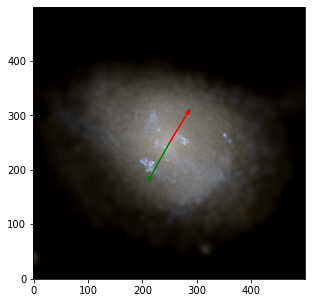

#### **cartesian label:** [-0.3174594   0.36468253]

#### **cartesian prediction (x_y):** [0.32653868 0.53367996]

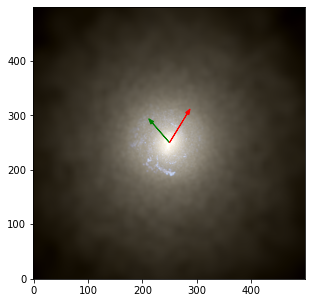

#### **cartesian label:** [ 0.6130155 -0.6018811]

#### **cartesian prediction (x_y):** [0.32278982 0.53486496]

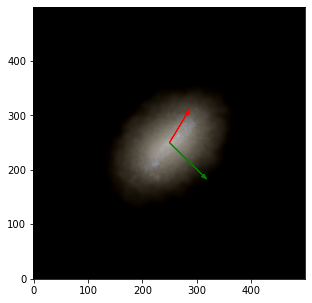

#### **cartesian label:** [ 0.8134941  -0.14679067]

#### **cartesian prediction (x_y):** [0.32135433 0.53533125]

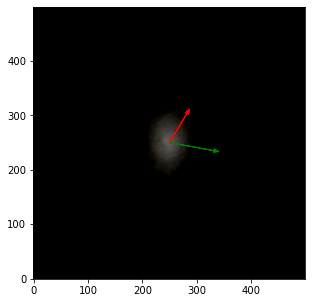

#### **cartesian label:** [0.4706139 0.3174854]

#### **cartesian prediction (x_y):** [0.32760173 0.53184086]

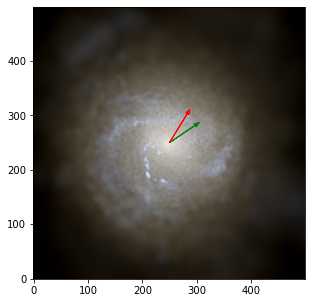

#### **cartesian label:** [0.13172308 0.03787146]

#### **cartesian prediction (x_y):** [0.32658306 0.5315642 ]

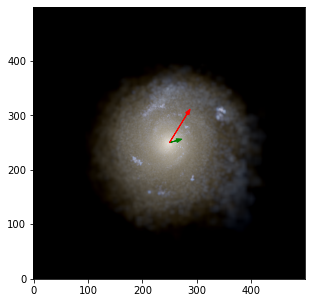

#### **cartesian label:** [-0.5015657  -0.49663258]

#### **cartesian prediction (x_y):** [0.3258469  0.53264785]

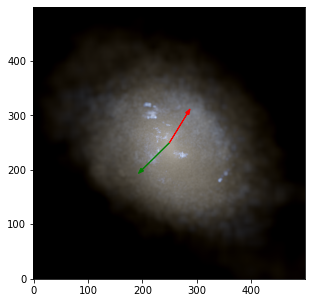

#### **cartesian label:** [0.7885064  0.03759363]

#### **cartesian prediction (x_y):** [0.32399282 0.534339  ]

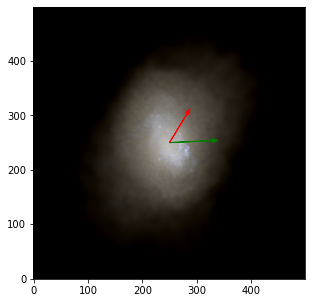

#### **cartesian label:** [ 0.4260015 -0.8465752]

#### **cartesian prediction (x_y):** [0.32189026 0.5351304 ]

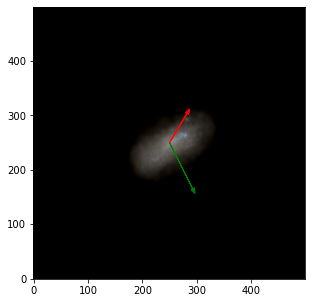

#### **cartesian label:** [ 0.18716548 -0.48423022]

#### **cartesian prediction (x_y):** [0.3234561 0.5345754]

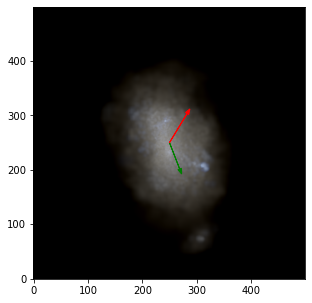

#### **cartesian label:** [-0.7344479  0.393269 ]

#### **cartesian prediction (x_y):** [0.3267966 0.5329892]

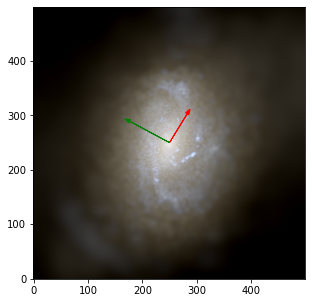

#### **cartesian label:** [0.13905302 0.03235175]

#### **cartesian prediction (x_y):** [0.32108125 0.53536695]

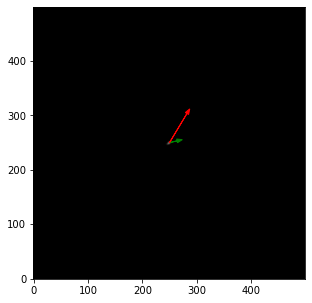

#### **cartesian label:** [-0.86945266  0.45658842]

#### **cartesian prediction (x_y):** [0.32146928 0.5353212 ]

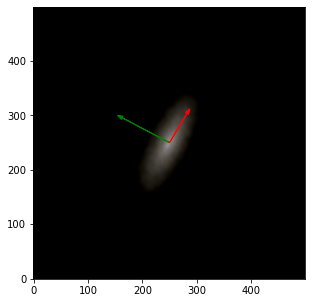

#### **cartesian label:** [ 0.27627823 -0.19978085]

#### **cartesian prediction (x_y):** [0.32131267 0.5352748 ]

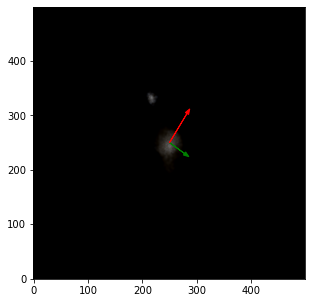

#### **cartesian label:** [ 0.28472102 -0.40975   ]

#### **cartesian prediction (x_y):** [0.32399127 0.53406703]

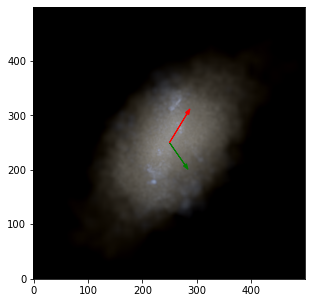

#### **cartesian label:** [-0.29573792  0.6313021 ]

#### **cartesian prediction (x_y):** [0.3230849 0.5347151]

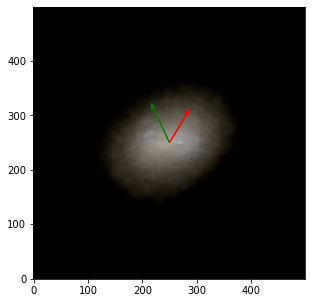

#### **cartesian label:** [0.7541334  0.38658357]

#### **cartesian prediction (x_y):** [0.32534686 0.5334075 ]

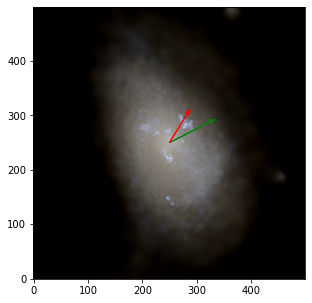

#### **cartesian label:** [ 0.659654  -0.6403829]

#### **cartesian prediction (x_y):** [0.32303002 0.5345539 ]

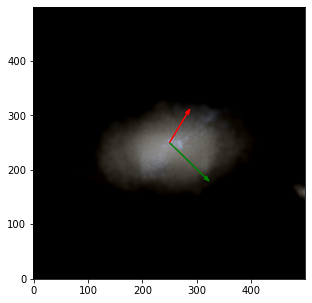

#### **cartesian label:** [0.4668033 0.7607461]

#### **cartesian prediction (x_y):** [0.3228188 0.534696 ]

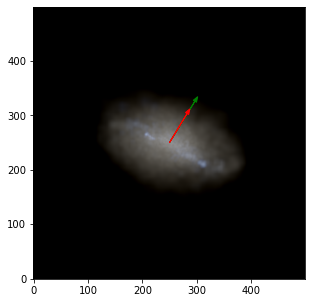

#### **cartesian label:** [0.31045863 0.71434635]

#### **cartesian prediction (x_y):** [0.32108378 0.5353746 ]

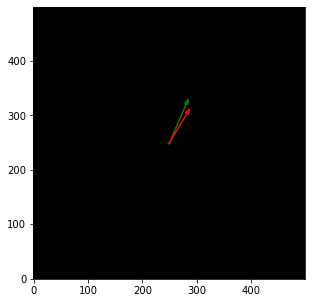

#### **cartesian label:** [0.2855879 0.8021056]

#### **cartesian prediction (x_y):** [0.326641   0.53314996]

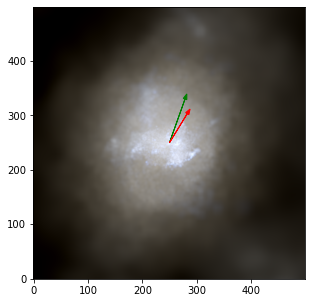

#### **cartesian label:** [-0.83063245  0.49420914]

#### **cartesian prediction (x_y):** [0.32185587 0.53501356]

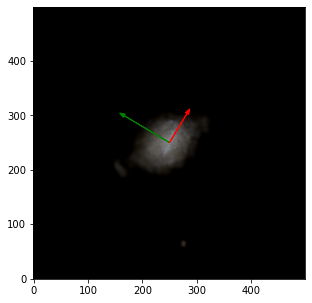

#### **cartesian label:** [-0.9642622  0.0903656]

#### **cartesian prediction (x_y):** [0.3210704 0.5353692]

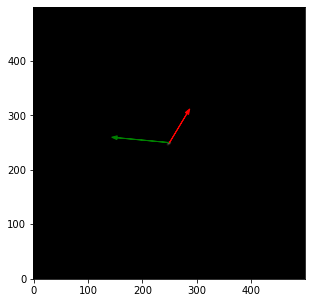

#### **cartesian label:** [0.85164475 0.51157606]

#### **cartesian prediction (x_y):** [0.32630298 0.53426844]

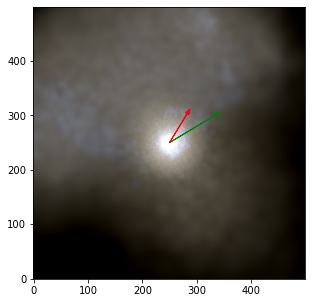

#### **cartesian label:** [-0.7217295   0.47217816]

#### **cartesian prediction (x_y):** [0.32450524 0.53361654]

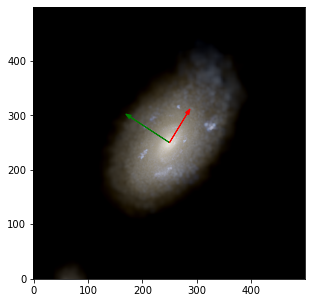

#### **cartesian label:** [-0.19023095 -0.1026924 ]

#### **cartesian prediction (x_y):** [0.326349   0.53330654]

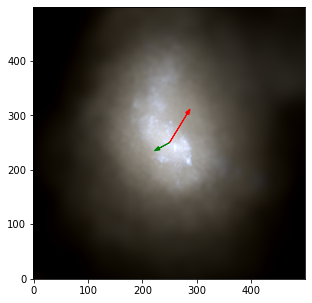

#### **cartesian label:** [-0.56980425 -0.13748847]

#### **cartesian prediction (x_y):** [0.32124478 0.53532475]

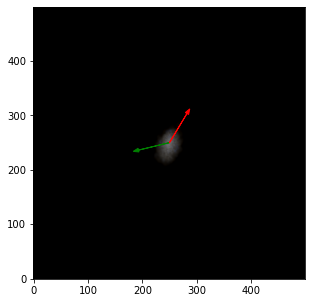

#### **cartesian label:** [0.5596505  0.11075325]

#### **cartesian prediction (x_y):** [0.32117167 0.53529054]

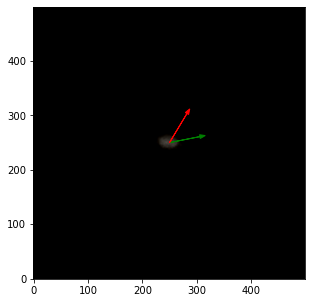

#### **cartesian label:** [0.57706183 0.41282573]

#### **cartesian prediction (x_y):** [0.32116643 0.53530985]

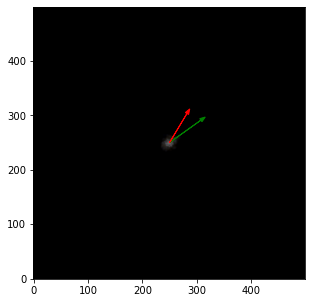

#### **cartesian label:** [-0.7162062 -0.4040838]

#### **cartesian prediction (x_y):** [0.32432005 0.5344335 ]

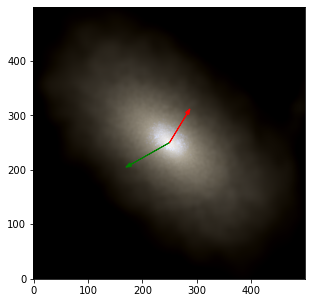

#### **cartesian label:** [ 0.4930079  -0.04662171]

#### **cartesian prediction (x_y):** [0.3256018 0.5335625]

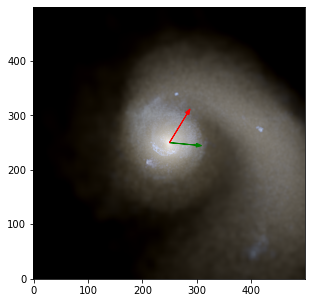

#### **cartesian label:** [ 0.932726   -0.02630288]

#### **cartesian prediction (x_y):** [0.32113895 0.5353566 ]

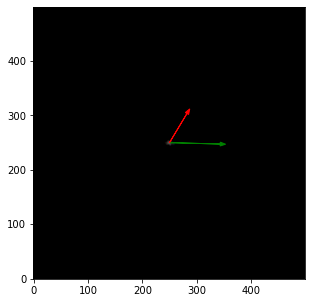

#### **cartesian label:** [0.9238208  0.01065692]

#### **cartesian prediction (x_y):** [0.3210821  0.53536606]

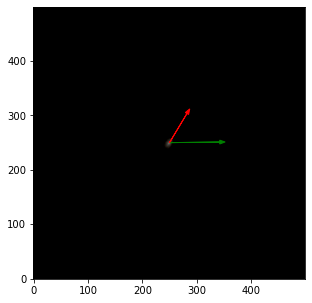

#### **cartesian label:** [-0.8953094 -0.3879809]

#### **cartesian prediction (x_y):** [0.32292846 0.535     ]

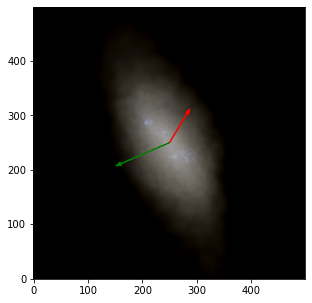

#### **cartesian label:** [0.8935543  0.36296165]

#### **cartesian prediction (x_y):** [0.32119963 0.53534335]

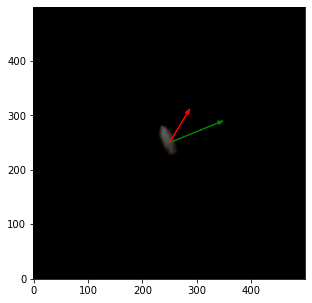

#### **cartesian label:** [ 0.72781646 -0.52398556]

#### **cartesian prediction (x_y):** [0.32275096 0.5345191 ]

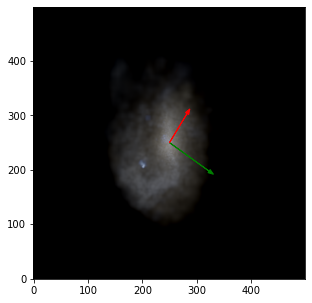

#### **cartesian label:** [-0.97094315  0.03806883]

#### **cartesian prediction (x_y):** [0.3250583  0.53337455]

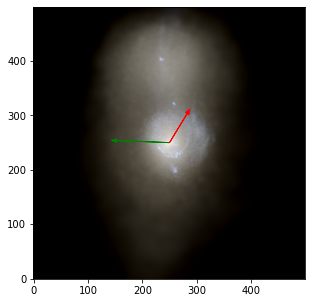

#### **cartesian label:** [ 0.1596858  -0.94184965]

#### **cartesian prediction (x_y):** [0.3244455 0.5346203]

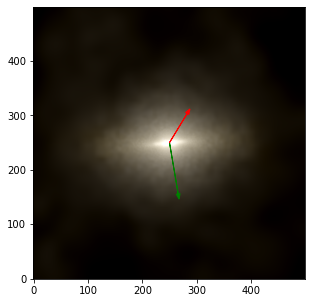

#### **cartesian label:** [0.7704682  0.21129374]

#### **cartesian prediction (x_y):** [0.32398406 0.5344443 ]

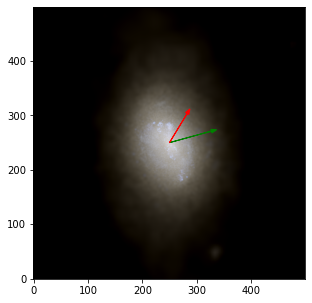

#### **cartesian label:** [ 0.97678137 -0.14014658]

#### **cartesian prediction (x_y):** [0.3226832  0.53492254]

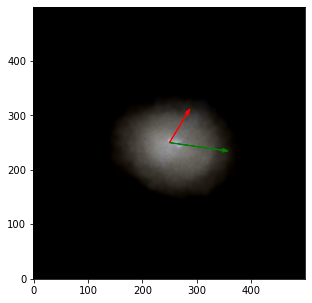

#### **cartesian label:** [-0.8092191   0.24175759]

#### **cartesian prediction (x_y):** [0.324351   0.53385955]

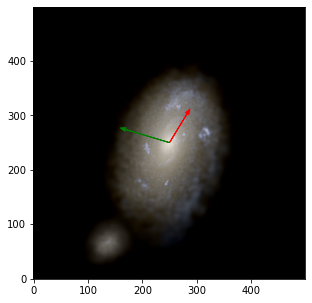

#### **cartesian label:** [-0.55651146 -0.5485653 ]

#### **cartesian prediction (x_y):** [0.32658657 0.53405184]

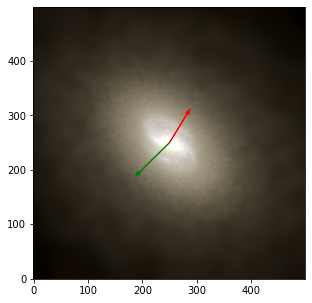

#### **cartesian label:** [ 0.5273886  -0.26173592]

#### **cartesian prediction (x_y):** [0.32206002 0.53503054]

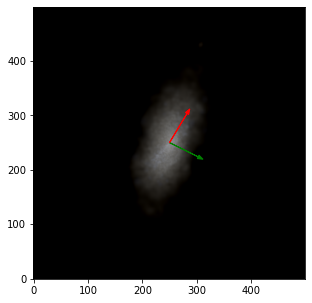

#### **cartesian label:** [-0.42454392  0.26744658]

#### **cartesian prediction (x_y):** [0.32129195 0.5353021 ]

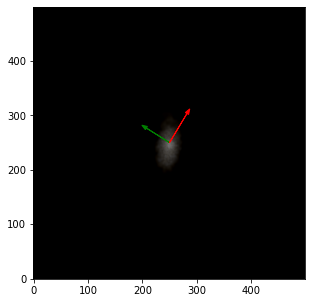

#### **cartesian label:** [ 0.69324106 -0.7194683 ]

#### **cartesian prediction (x_y):** [0.32115933 0.5353258 ]

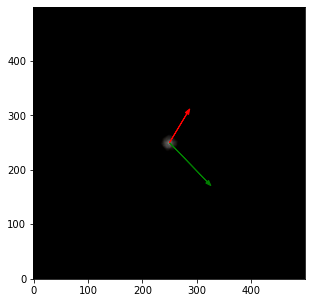

#### **cartesian label:** [ 0.4049916  -0.65509707]

#### **cartesian prediction (x_y):** [0.32139206 0.5352258 ]

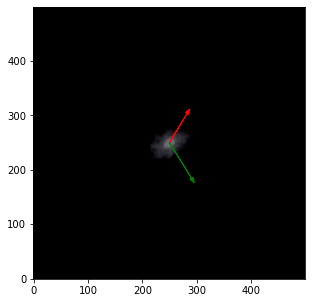

#### **cartesian label:** [0.9352682  0.22031619]

#### **cartesian prediction (x_y):** [0.32106212 0.53539205]

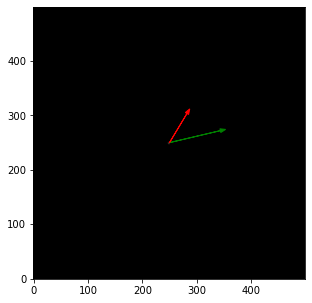

#### **cartesian label:** [ 0.8192357  -0.57056385]

#### **cartesian prediction (x_y):** [0.32442194 0.53489834]

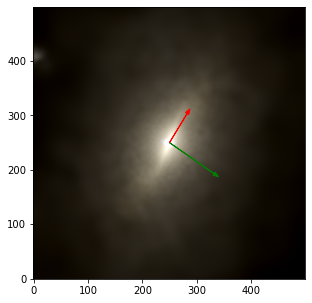

#### **cartesian label:** [ 0.63123226 -0.734447  ]

#### **cartesian prediction (x_y):** [0.3212414 0.5353155]

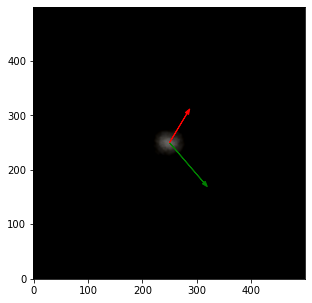

#### **cartesian label:** [-0.73368925  0.0586144 ]

#### **cartesian prediction (x_y):** [0.32672605 0.53274447]

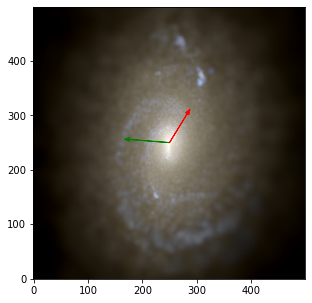

#### **cartesian label:** [ 0.5525759  -0.79181445]

#### **cartesian prediction (x_y):** [0.3214978  0.53521967]

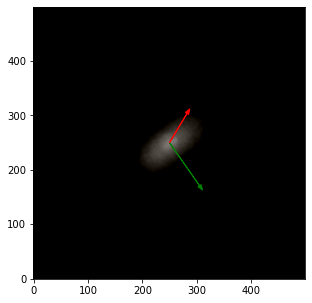

#### **cartesian label:** [ 0.7952049  -0.15544084]

#### **cartesian prediction (x_y):** [0.32443985 0.53501475]

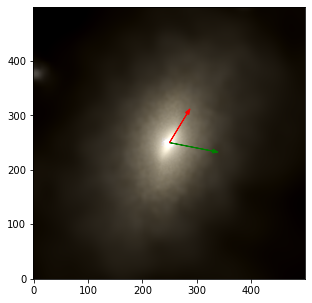

#### **cartesian label:** [-0.45009202 -0.2346122 ]

#### **cartesian prediction (x_y):** [0.3237925 0.5343872]

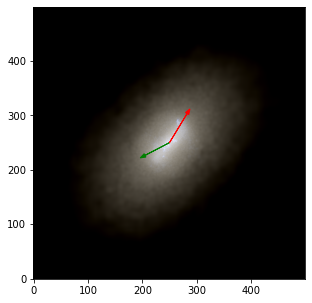

#### **cartesian label:** [-0.8714351   0.37229306]

#### **cartesian prediction (x_y):** [0.3211241  0.53532237]

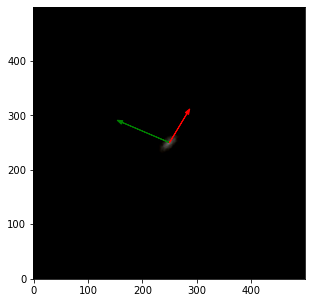

#### **cartesian label:** [-0.2436671 -0.8505494]

#### **cartesian prediction (x_y):** [0.32115647 0.5353432 ]

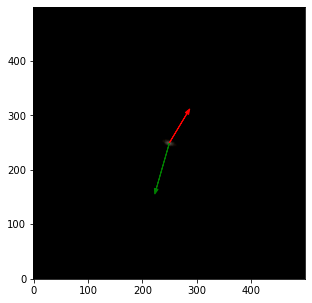

#### **cartesian label:** [-0.8805417  -0.29653618]

#### **cartesian prediction (x_y):** [0.32257664 0.5349905 ]

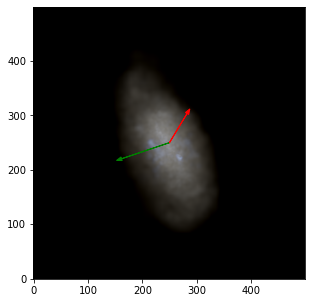

#### **cartesian label:** [ 0.6706876 -0.7416983]

#### **cartesian prediction (x_y):** [0.32346722 0.5345684 ]

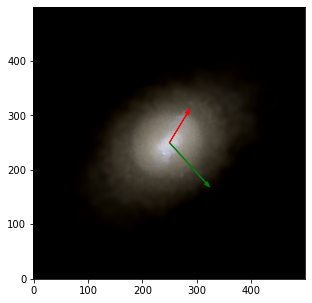

#### **cartesian label:** [-0.62615955  0.23343383]

#### **cartesian prediction (x_y):** [0.3212181 0.5353052]

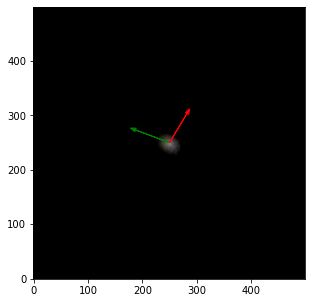

#### **cartesian label:** [-0.6851723   0.33154833]

#### **cartesian prediction (x_y):** [0.3257151 0.5327266]

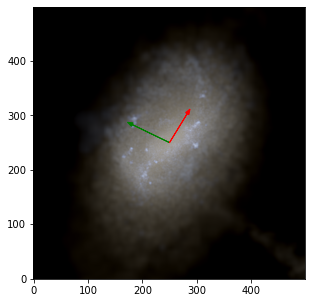

#### **cartesian label:** [-0.33710024  0.72459656]

#### **cartesian prediction (x_y):** [0.32284108 0.5349583 ]

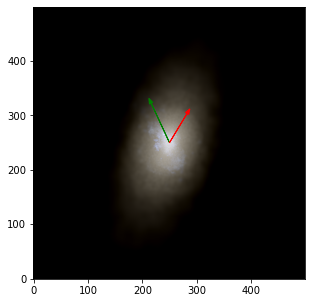

#### **cartesian label:** [ 0.9755133  -0.17469037]

#### **cartesian prediction (x_y):** [0.32110074 0.5353785 ]

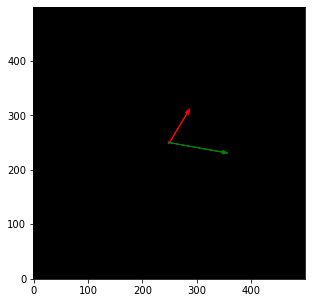

#### **cartesian label:** [ 0.5983401  -0.55499464]

#### **cartesian prediction (x_y):** [0.324224  0.5341211]

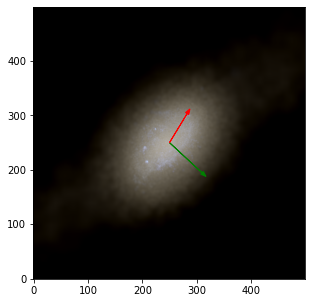

#### **cartesian label:** [-0.8305735   0.04310169]

#### **cartesian prediction (x_y):** [0.3245546  0.53450316]

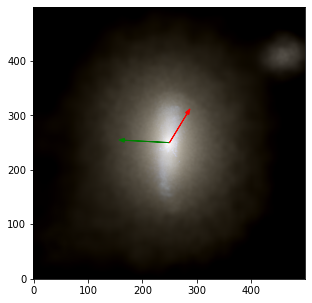

#### **cartesian label:** [-0.20417523 -0.9735443 ]

#### **cartesian prediction (x_y):** [0.32702222 0.5334274 ]

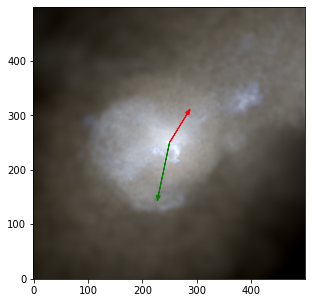

#### **cartesian label:** [0.2971071 0.6188163]

#### **cartesian prediction (x_y):** [0.3242985  0.53381145]

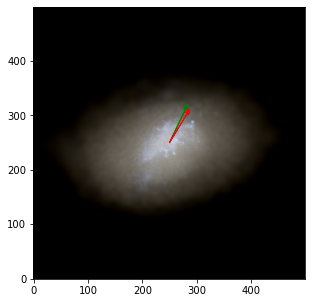

#### **cartesian label:** [-0.9220268  0.0066615]

#### **cartesian prediction (x_y):** [0.3243865 0.5341888]

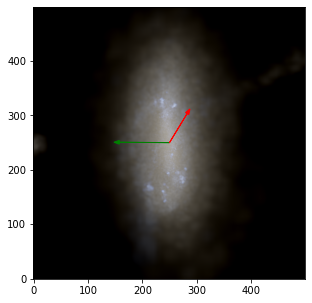

#### **cartesian label:** [ 0.87489325 -0.48406422]

#### **cartesian prediction (x_y):** [0.32356462 0.5345118 ]

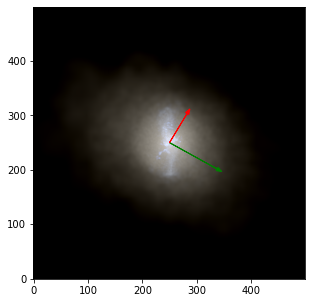

#### **cartesian label:** [-0.18185571  0.07745082]

#### **cartesian prediction (x_y):** [0.32102486 0.53543323]

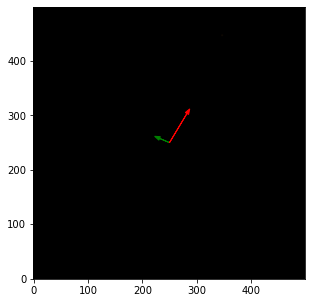

#### **cartesian label:** [ 0.02731373 -0.14187984]

#### **cartesian prediction (x_y):** [0.32136664 0.5352523 ]

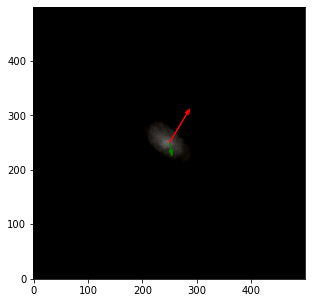

#### **cartesian label:** [-0.706819  -0.6502946]

#### **cartesian prediction (x_y):** [0.32143015 0.5352909 ]

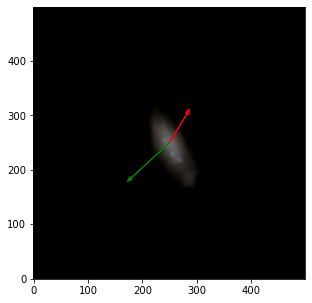

#### **cartesian label:** [ 0.77115655 -0.37864634]

#### **cartesian prediction (x_y):** [0.3211705  0.53532755]

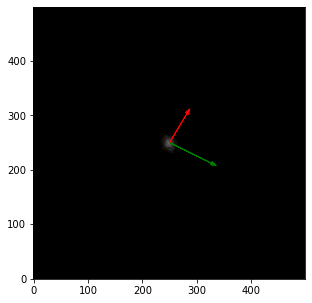

#### **cartesian label:** [-0.9735554  -0.21107914]

#### **cartesian prediction (x_y):** [0.32420495 0.5344589 ]

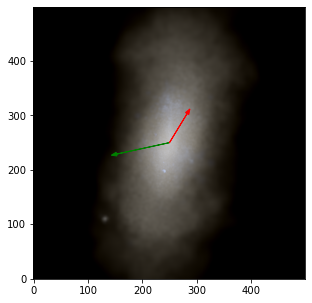

#### **cartesian label:** [-0.5720274  -0.29122525]

#### **cartesian prediction (x_y):** [0.32152346 0.5353306 ]

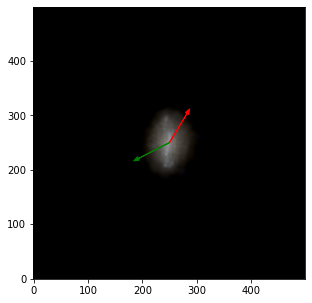

#### **cartesian label:** [-0.34911376  0.14307815]

#### **cartesian prediction (x_y):** [0.32109132 0.5353609 ]

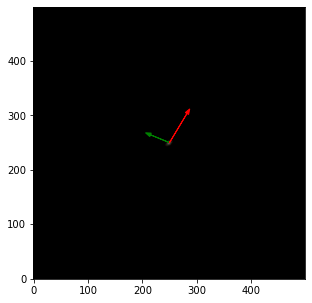

#### **cartesian label:** [-0.00313967  0.0586014 ]

#### **cartesian prediction (x_y):** [0.3250148 0.5332398]

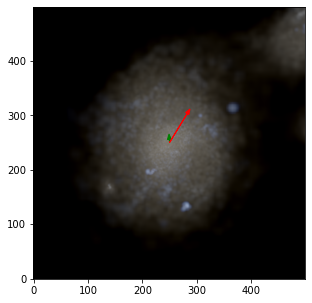

#### **cartesian label:** [ 0.6877297  -0.16112445]

#### **cartesian prediction (x_y):** [0.32327035 0.5349595 ]

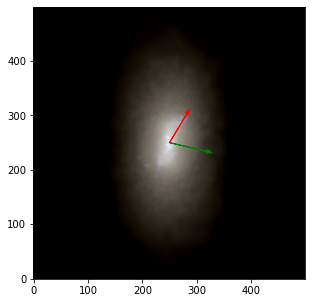

#### **cartesian label:** [ 0.37695408 -0.0434731 ]

#### **cartesian prediction (x_y):** [0.32393503 0.5356627 ]

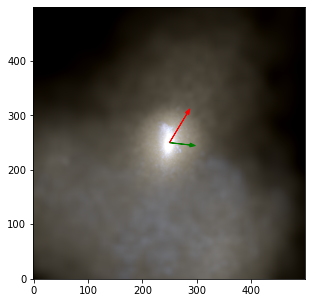

#### **cartesian label:** [ 0.4031603  -0.82045996]

#### **cartesian prediction (x_y):** [0.32168937 0.5352114 ]

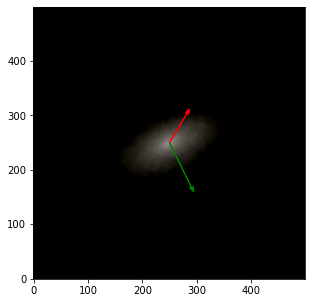

#### **cartesian label:** [0.06415728 0.92966604]

#### **cartesian prediction (x_y):** [0.32463893 0.53374857]

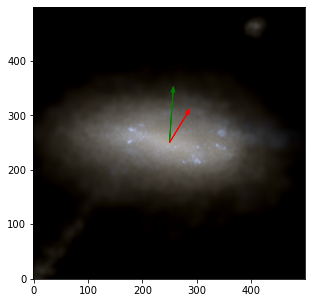

#### **cartesian label:** [-0.09442877  0.7325543 ]

#### **cartesian prediction (x_y):** [0.32641968 0.53247833]

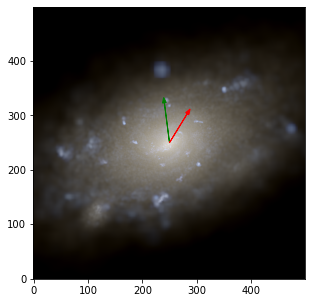

#### **cartesian label:** [ 0.7166734 -0.5279953]

#### **cartesian prediction (x_y):** [0.3210204  0.53543156]

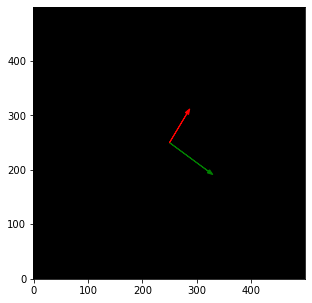

#### **cartesian label:** [-0.9770537  -0.02055166]

#### **cartesian prediction (x_y):** [0.32688305 0.5334428 ]

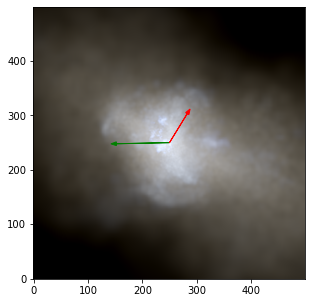

#### **cartesian label:** [-0.96975285 -0.22252853]

#### **cartesian prediction (x_y):** [0.32576278 0.5350335 ]

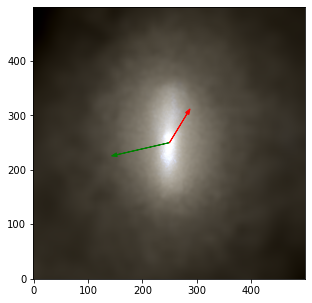

#### **cartesian label:** [-0.720993  -0.4859109]

#### **cartesian prediction (x_y):** [0.32221797 0.5349536 ]

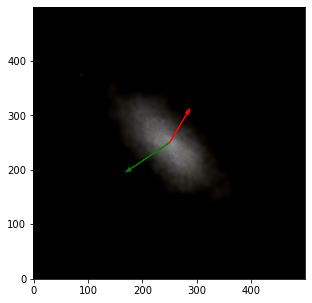

#### **cartesian label:** [-0.9807727  -0.00830508]

#### **cartesian prediction (x_y):** [0.32157293 0.5353593 ]

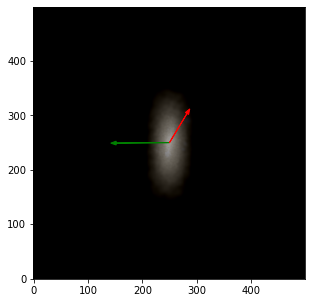

#### **cartesian label:** [-0.44115812 -0.33743516]

#### **cartesian prediction (x_y):** [0.32446966 0.5332827 ]

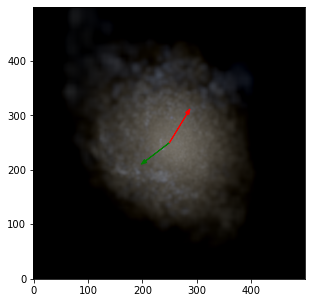

#### **cartesian label:** [ 0.2772665 -0.914736 ]

#### **cartesian prediction (x_y):** [0.32111955 0.53536713]

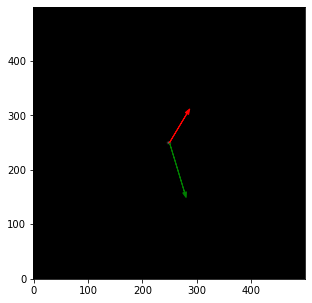

#### **cartesian label:** [0.8553011 0.4403618]

#### **cartesian prediction (x_y):** [0.32117692 0.53533036]

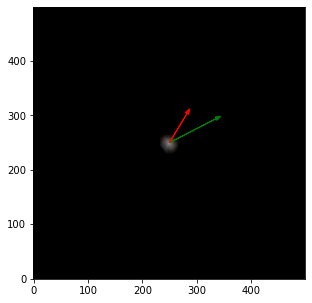

#### **cartesian label:** [-0.6530812  -0.70033514]

#### **cartesian prediction (x_y):** [0.32178706 0.5351358 ]

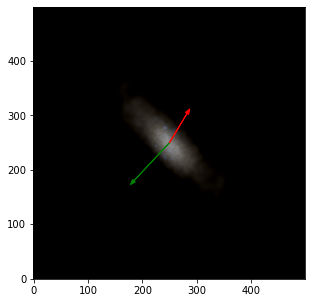

#### **cartesian label:** [ 0.28263298 -0.29043528]

#### **cartesian prediction (x_y):** [0.32130623 0.53530824]

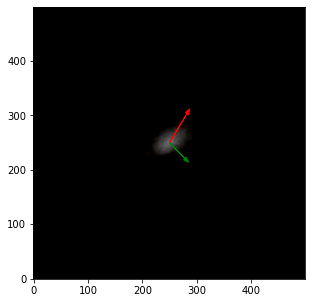

#### **cartesian label:** [-0.9647554   0.07812783]

#### **cartesian prediction (x_y):** [0.32524356 0.5344982 ]

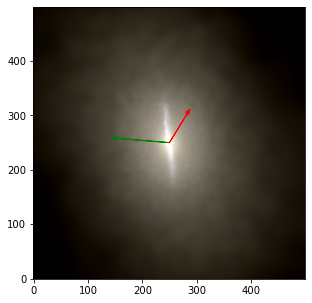

#### **cartesian label:** [-0.3731995  -0.02834715]

#### **cartesian prediction (x_y):** [0.32166597 0.5351799 ]

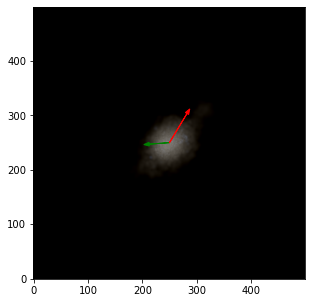

#### **cartesian label:** [-0.6110866  -0.01497061]

#### **cartesian prediction (x_y):** [0.32115   0.5353535]

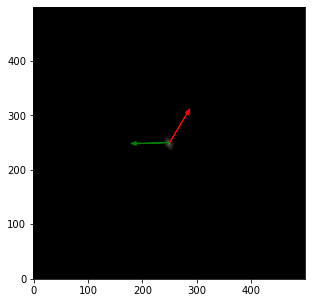

#### **cartesian label:** [-0.9988021  0.0388277]

#### **cartesian prediction (x_y):** [0.32124227 0.53535074]

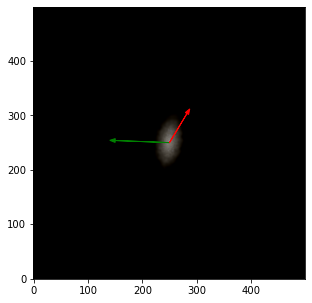

#### **cartesian label:** [ 0.3363204  -0.39548257]

#### **cartesian prediction (x_y):** [0.32116404 0.5353541 ]

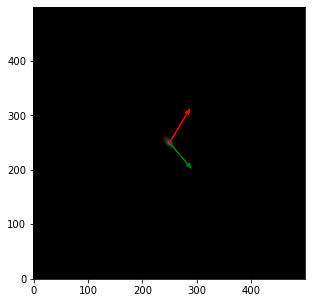

#### **cartesian label:** [-0.09093975  0.48050797]

#### **cartesian prediction (x_y):** [0.32231298 0.5350792 ]

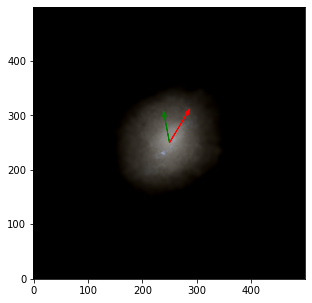

#### **cartesian label:** [ 0.80465096 -0.01805254]

#### **cartesian prediction (x_y):** [0.32200494 0.53525954]

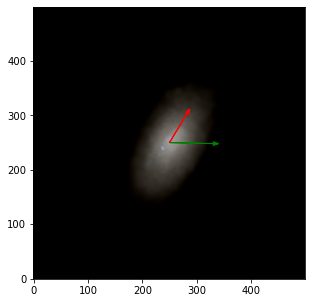

#### **cartesian label:** [0.54921263 0.00715058]

#### **cartesian prediction (x_y):** [0.3234708 0.534843 ]

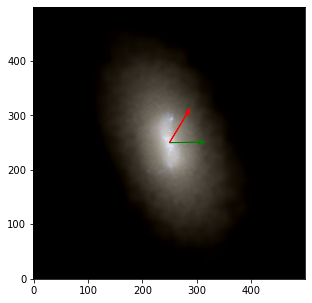

#### **cartesian label:** [ 0.94698536 -0.28677484]

#### **cartesian prediction (x_y):** [0.3233263  0.53463596]

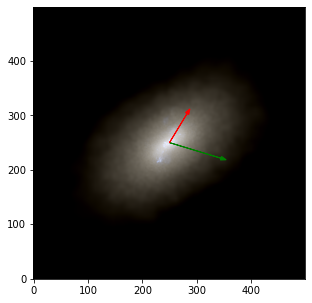

#### **cartesian label:** [ 0.32748777 -0.90499276]

#### **cartesian prediction (x_y):** [0.32349142 0.5340083 ]

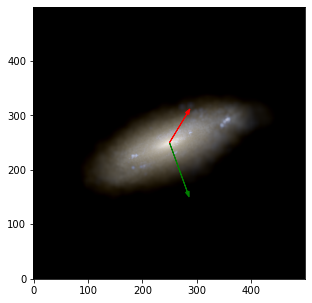

#### **cartesian label:** [-0.13314693 -0.60516286]

#### **cartesian prediction (x_y):** [0.32175103 0.5351077 ]

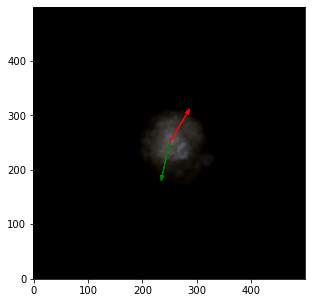

In [22]:
# visualicing the results
for img,label,pred in zip(images,labels,outputs):
    viz(img, label, pred)